<a href="https://colab.research.google.com/github/LimJavier/Weatherwise-Javier-Lim/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [ ]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus

In [2]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: 71f0222d3be04e5084fdf890ecee4e28.spCIJMbYVjy7q_m7T9ATSbTW


## 📦 Setup and Configuration
Import required packages and setup environment.

In [11]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Add any other setup code here
import time
import fetch_my_weather
import hands_on_ai
import re
import logging
from datetime import datetime, timedelta
from typing import Dict, Any, Optional, List

# Try to import ipywidgets for Jupyter/interactive mode
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output, HTML
    JUPYTER_AVAILABLE = True
except ImportError:
    JUPYTER_AVAILABLE = False
    print("⚠️  ipywidgets not available. Interactive mode disabled.")

# Set up logging
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger(__name__)

## 🌤️ Weather Data Functions

In [4]:
# Define get_weather_data() function here
def get_weather_data(location, units="metric", forecast_days=0, max_retries=3):
    """
    Retrieve weather data for a specified location with optional forecast days.

    Args:
        location (str): City name (e.g., "Perth") or "City,Country" (e.g., "Perth,AU").
        units (str): "metric" (°C) or "imperial" (°F). Default is "metric".
        forecast_days (int): Number of days to forecast (0 = current weather only). Max = 5.
        max_retries (int): Number of retry attempts for connection errors. Default = 3.

    Returns:
        dict: Structured weather information including:
            - location: Verified location name and country
            - current: Current weather data (temperature, humidity, description, wind speed)
            - forecast: List of daily forecasts (if forecast_days > 0)
            - summary: Human-readable weather summary

    Raises:
        ValueError: Invalid parameters, location, or API key.
        ConnectionError: Unable to connect after retries.
    """

    API_KEY = "16d5a3f7e99677a7415465b4d0268f45"
    CURRENT_URL = "https://api.openweathermap.org/data/2.5/weather"
    FORECAST_URL = "https://api.openweathermap.org/data/2.5/forecast"

    def request_with_retries(url, params, retries=max_retries):
        """Helper: Retry request if connection fails."""
        attempt = 0
        while attempt < retries:
            try:
                response = requests.get(url, params=params, timeout=10)
                if response.status_code == 401:
                    raise ValueError("Invalid API key. Please check your OpenWeatherMap API key.")
                if response.status_code == 404:
                    raise ValueError(f"Location '{location}' not found. Please check the location name.")
                response.raise_for_status()
                return response.json()
            except requests.exceptions.RequestException as e:
                attempt += 1
                if attempt >= retries:
                    raise ConnectionError(f"Failed to connect after {retries} attempts: {e}")
                print(f"[Warning] Attempt {attempt} failed: {e}. Retrying...")
                time.sleep(2)

    # Validate forecast_days parameter
    if not isinstance(forecast_days, int) or forecast_days < 0 or forecast_days > 5:
        raise ValueError("forecast_days must be an integer between 0 and 5.")

    # Fetch current weather
    params = {"q": location, "appid": API_KEY, "units": units}
    current_data = request_with_retries(CURRENT_URL, params)

    if current_data.get("cod") != 200:
        error_message = current_data.get("message", "Unknown error")
        if "invalid api key" in error_message.lower():
            raise ValueError("Invalid API key. Please check your API key in OpenWeatherMap.")
        elif "city not found" in error_message.lower():
            raise ValueError(f"Location '{location}' not found. Please check the spelling.")
        else:
            raise ValueError(f"Error from API: {error_message}")

    current_weather = {
        "temperature": current_data["main"]["temp"],
        "humidity": current_data["main"]["humidity"],
        "description": current_data["weather"][0]["description"].capitalize(),
        "wind_speed": current_data["wind"]["speed"],
    }

    weather_output = {
        "location": f"{current_data.get('name')}, {current_data.get('sys', {}).get('country')}",
        "current": current_weather,
        "forecast": [],
        "summary": f"Current weather in {current_data.get('name')}: {current_weather['description']}, "
                   f"{current_weather['temperature']}° with {current_weather['humidity']}% humidity."
    }

    # Fetch forecast if requested
    if forecast_days > 0:
        forecast_params = {"q": location, "appid": API_KEY, "units": units}
        forecast_data = request_with_retries(FORECAST_URL, forecast_params)

        if forecast_data.get("cod") != "200":
            error_message = forecast_data.get("message", "Unknown error")
            raise ValueError(f"Forecast error: {error_message}")

        daily_forecast = {}
        for entry in forecast_data["list"]:
            date = entry["dt_txt"].split(" ")[0]
            if date not in daily_forecast:
                daily_forecast[date] = {
                    "temperature_min": entry["main"]["temp_min"],
                    "temperature_max": entry["main"]["temp_max"],
                    "description": entry["weather"][0]["description"].capitalize()
                }
            else:
                daily_forecast[date]["temperature_min"] = min(daily_forecast[date]["temperature_min"], entry["main"]["temp_min"])
                daily_forecast[date]["temperature_max"] = max(daily_forecast[date]["temperature_max"], entry["main"]["temp_max"])

        sorted_dates = sorted(daily_forecast.keys())
        weather_output["forecast"] = [
            {"date": d, **daily_forecast[d]} for d in sorted_dates[:forecast_days]
        ]

        weather_output["summary"] += f" Forecast available for next {forecast_days} day(s)."

    return weather_output

# Testing for weather data retrieval
try:
    weather = get_weather_data("Iceland", units="metric", forecast_days=5)
    print(weather["summary"])
    print("Current:", weather["current"])
    if weather["forecast"]:
        print("Forecast:")
        for day in weather["forecast"]:
            print(day)
except ValueError as ve:
    print(f"[ValueError] {ve}")
except ConnectionError as ce:
    print(f"[ConnectionError] {ce}")
except Exception as e:
    print(f"[Error] {e}")

Current weather in Iceland: Overcast clouds, 7.27° with 98% humidity. Forecast available for next 5 day(s).
Current: {'temperature': 7.27, 'humidity': 98, 'description': 'Overcast clouds', 'wind_speed': 5.89}
Forecast:
{'date': '2025-10-12', 'temperature_min': 6.44, 'temperature_max': 6.81, 'description': 'Light rain'}
{'date': '2025-10-13', 'temperature_min': 2.74, 'temperature_max': 5.43, 'description': 'Overcast clouds'}
{'date': '2025-10-14', 'temperature_min': 2.96, 'temperature_max': 6.37, 'description': 'Overcast clouds'}
{'date': '2025-10-15', 'temperature_min': 3.5, 'temperature_max': 7.26, 'description': 'Light rain'}
{'date': '2025-10-16', 'temperature_min': 1.34, 'temperature_max': 4.04, 'description': 'Scattered clouds'}


## 📊 Visualisation Functions

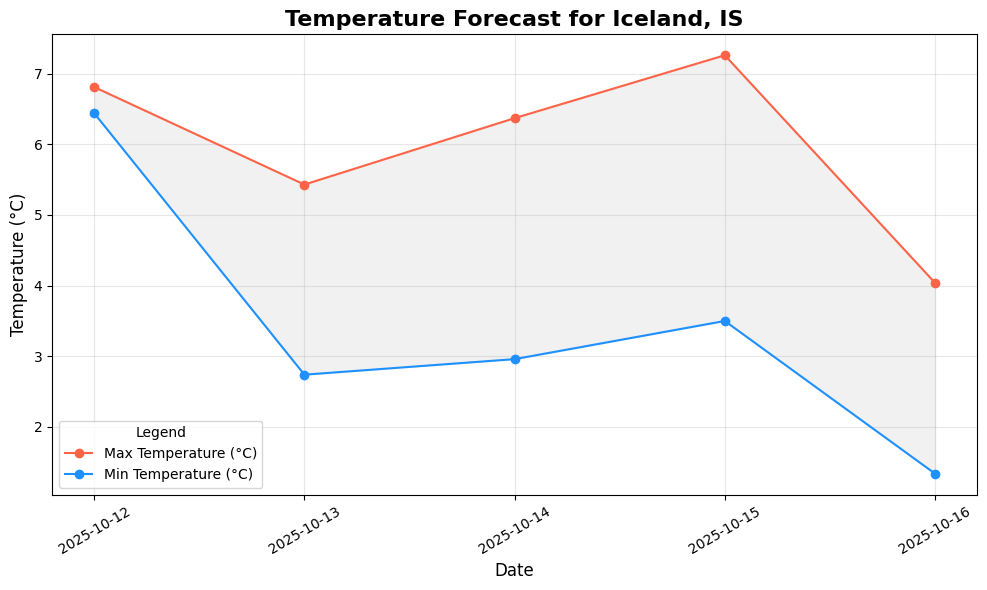

In [5]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create a temperature trend visualisation from processed weather forecast data.

    Purpose:
        To plot the minimum and maximum temperature trends for a location over forecast days,
        enhancing data readability for analysis or reporting.

    Args:
        weather_data (dict): Processed weather data containing:
            - location (str): Location name (e.g., "Perth, AU").
            - forecast (list of dict): Forecast list with each entry containing:
                * 'date' (str): Date in YYYY-MM-DD format.
                * 'temperature_min' (float): Minimum temperature for the day.
                * 'temperature_max' (float): Maximum temperature for the day.
        output_type (str): Determines output behaviour:
            - 'display': Display the chart directly.
            - 'return': Return the Matplotlib figure object for further use.

    Returns:
        matplotlib.figure.Figure or None:
            - Returns the figure object if output_type='return'.
            - Returns None if output_type='display'.
    Raises:
        ValueError: If forecast data is missing or incomplete.
        TypeError: If input data format is incorrect.
    """

    # Validate forecast data
    if not weather_data or "forecast" not in weather_data:
        raise ValueError("Missing weather forecast data.")

    forecast = weather_data["forecast"]
    if not isinstance(forecast, list) or len(forecast) == 0:
        raise ValueError("Forecast data must be a non-empty list.")

    # Extract dates and temperatures with error handling
    dates = []
    temp_min = []
    temp_max = []
    for entry in forecast:
        try:
            dates.append(entry["date"])
            temp_min.append(float(entry["temperature_min"]))
            temp_max.append(float(entry["temperature_max"]))
        except (KeyError, TypeError, ValueError):
            raise ValueError("Forecast entries must contain valid 'date', 'temperature_min', and 'temperature_max'.")

    # Check for extreme or missing values
    if any(t is None for t in temp_min + temp_max):
        raise ValueError("Temperature data contains None values.")
    if any(abs(t) > 100 for t in temp_min + temp_max):  # Extreme check
        raise ValueError("Temperature data contains unrealistic values.")

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(dates, temp_max, label="Max Temperature (°C)", color="tomato", marker="o")
    ax.plot(dates, temp_min, label="Min Temperature (°C)", color="dodgerblue", marker="o")
    ax.fill_between(dates, temp_min, temp_max, color="lightgray", alpha=0.3)

    # Improve readability
    ax.set_title(f"Temperature Forecast for {weather_data.get('location', 'Unknown Location')}", fontsize=16, weight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(alpha=0.3)
    ax.legend(title="Legend", fontsize=10)

    plt.tight_layout()

    # Display or return figure
    if output_type == 'display':
        plt.show()
        return None
    elif output_type == 'return':
        return fig
    else:
        raise ValueError("Invalid output_type. Use 'display' or 'return'.")

# Testing for temperature visualisation
weather_data = get_weather_data(location="Iceland", forecast_days=5)
create_temperature_visualisation(weather_data, output_type="display")


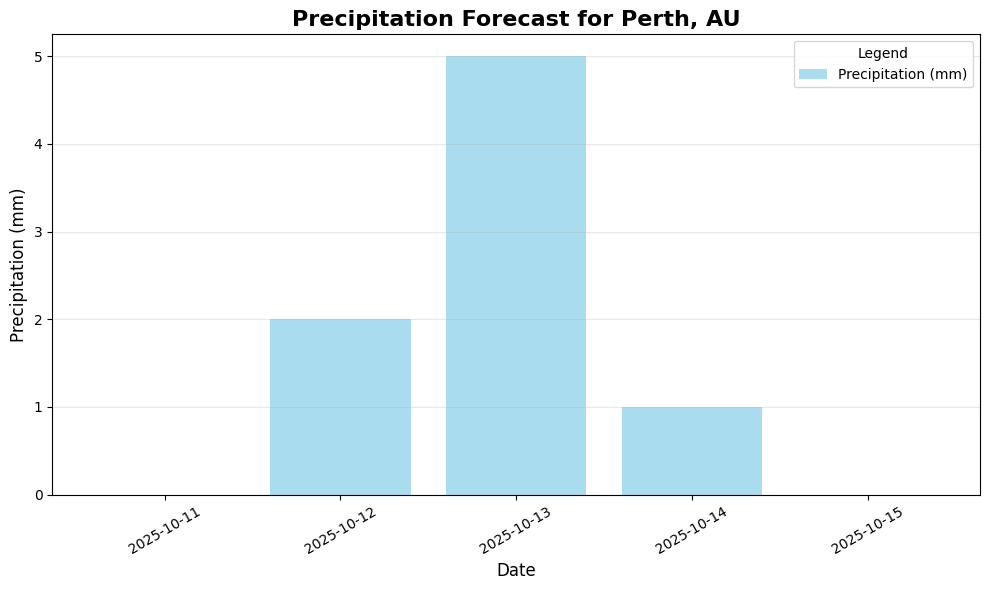

In [6]:

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create a precipitation trend visualisation from processed weather forecast data.

    Purpose:
        To plot daily precipitation trends for a location over forecast days,
        making precipitation patterns easy to interpret.

    Args:
        weather_data (dict): Processed weather data containing:
            - location (str): Location name (e.g., "Perth, AU").
            - forecast (list of dict): Forecast list with each entry containing:
                * 'date' (str): Date in YYYY-MM-DD format.
                * 'precipitation' (float): Precipitation in millimeters for the day.
        output_type (str): Determines output behaviour:
            - 'display': Display the chart directly.
            - 'return': Return the Matplotlib figure object for further use.

    Returns:
        matplotlib.figure.Figure or None:
            - Returns the figure object if output_type='return'.
            - Returns None if output_type='display'.

    Raises:
        ValueError: If forecast data is missing or incomplete.
        TypeError: If input data format is incorrect.
    """

    # Validate forecast data
    if not weather_data or "forecast" not in weather_data:
        raise ValueError("Missing weather forecast data.")

    forecast = weather_data["forecast"]
    if not isinstance(forecast, list) or len(forecast) == 0:
        raise ValueError("Forecast data must be a non-empty list.")

    # Extract dates and precipitation values
    dates = []
    precipitation = []
    for entry in forecast:
        try:
            dates.append(entry["date"])
            precipitation.append(float(entry.get("precipitation", 0)))
        except (KeyError, TypeError, ValueError):
            raise ValueError("Forecast entries must contain valid 'date' and 'precipitation' values.")

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(dates, precipitation, color="skyblue", alpha=0.7, label="Precipitation (mm)")

    # Improve readability
    ax.set_title(f"Precipitation Forecast for {weather_data.get('location', 'Unknown Location')}", fontsize=16, weight='bold')
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Precipitation (mm)", fontsize=12)
    ax.tick_params(axis='x', rotation=30)
    ax.grid(alpha=0.3, axis='y')
    ax.legend(title="Legend", fontsize=10)

    plt.tight_layout()

    # Display or return figure
    if output_type == 'display':
        plt.show()
        return None
    elif output_type == 'return':
        return fig
    else:
        raise ValueError("Invalid output_type. Use 'display' or 'return'.")

# Testing for percipitation visualisation
weather_data = {
    "location": "Perth, AU",
    "forecast": [
        {"date": "2025-10-11", "temperature_min": 19, "temperature_max": 29, "precipitation": 0},
        {"date": "2025-10-12", "temperature_min": 18, "temperature_max": 27, "precipitation": 2},
        {"date": "2025-10-13", "temperature_min": 20, "temperature_max": 30, "precipitation": 5},
        {"date": "2025-10-14", "temperature_min": 17, "temperature_max": 28, "precipitation": 1},
        {"date": "2025-10-15", "temperature_min": 16, "temperature_max": 26, "precipitation": 0}
    ]
}

create_precipitation_visualisation(weather_data, output_type='display')

## 🤖 Natural Language Processing

In [7]:
# Define parse_weather_question() and generate_weather_response() here
def parse_weather_question(question: Any, default_location: Optional[str] = None) -> Dict[str, Any]:
    """
    Parse a weather-related question and extract key information.

    Args:
        question: The user's weather question
        default_location: Default location to use if none is found

    Returns:
        Dictionary containing location, time_period, attribute, query_type, error, and confidence
    """
    # Initialize result structure with error field
    result = {
        "location": None,
        "time_period": None,
        "attribute": None,
        "query_type": None,
        "error": None,
        "confidence": "high"
    }

    try:
        # Step 1: Handle empty or invalid input
        if question is None:
            result["error"] = "Empty input: No question provided"
            return result

        if not isinstance(question, str):
            result["error"] = "Invalid input type: Question must be a string"
            return result

        # Step 2: Preprocess the question
        normalized_question = question.strip()

        if not normalized_question or len(normalized_question) < 3:
            result["error"] = "Invalid input: Question too short or empty"
            return result

        normalized_question = normalized_question.lower()

        # Step 3: Check if question is weather-related
        weather_indicators = [
            "weather", "rain", "temperature", "wind", "snow", "cloud",
            "sunny", "hot", "cold", "warm", "cool", "storm", "forecast",
            "humid", "fog", "drizzle", "precipitation", "degrees"
        ]

        is_weather_related = any(indicator in normalized_question for indicator in weather_indicators)

        if not is_weather_related:
            result["error"] = "Not a weather question: Unable to identify weather-related keywords"
            result["confidence"] = "low"
            # Continue processing anyway

        # Step 4: Extract location with error handling
        try:
            # Try regex pattern for "in/at [Location]"
            location_pattern = r'\b(?:in|at)\s+([A-Z][a-zA-Z\s]+?)(?:\s|$|\?|,)'
            match = re.search(location_pattern, question)
            if match:
                result["location"] = match.group(1).strip()

            # Also try to find capitalized words that might be locations
            if result["location"] is None:
                # Look for capitalized words (likely place names)
                cap_pattern = r'\b([A-Z][a-z]+(?:\s[A-Z][a-z]+)*)\b'
                matches = re.findall(cap_pattern, question)
                if matches:
                    # Filter out common words that aren't locations
                    non_locations = {"Will", "What", "How", "When", "Where", "Is", "The", "A", "An"}
                    locations = [m for m in matches if m not in non_locations]
                    if locations:
                        result["location"] = locations[0]

        except Exception as e:
            logger.warning(f"Location extraction failed: {str(e)}")
            result["confidence"] = "medium"

        # Handle ambiguous or missing location
        if result["location"] is None:
            if default_location:
                result["location"] = default_location
                result["confidence"] = "medium"
            else:
                result["error"] = "Missing location: Unable to determine location from question"
                result["confidence"] = "low"

        # Step 5: Extract time period with error handling
        try:
            result["time_period"] = extract_time_period(normalized_question)

            # Handle ambiguous time references
            ambiguous_terms = ["soon", "later", "future", "past"]
            for term in ambiguous_terms:
                if term in normalized_question and result["time_period"] is None:
                    result["error"] = f"Ambiguous time reference: '{term}' is too vague"
                    result["confidence"] = "low"
                    break

            # Default to today if no time mentioned
            if result["time_period"] is None:
                result["time_period"] = datetime.now().strftime("%Y-%m-%d")
                result["confidence"] = "medium"

        except Exception as e:
            logger.warning(f"Time extraction failed: {str(e)}")
            result["time_period"] = datetime.now().strftime("%Y-%m-%d")
            result["confidence"] = "low"

        # Step 6: Extract weather attribute with validation
        try:
            attribute_keywords = {
                "rain": ["rain", "raining", "rainy", "precipitation", "drizzle", "shower"],
                "temperature": ["temperature", "hot", "cold", "warm", "cool", "degrees", "temp"],
                "wind": ["wind", "windy", "breeze", "gust"],
                "snow": ["snow", "snowing", "snowy", "sleet"],
                "clouds": ["cloud", "cloudy", "overcast", "sky"],
                "humidity": ["humid", "humidity", "moisture"],
                "sun": ["sun", "sunny", "sunshine", "clear"],
                "storm": ["storm", "stormy", "thunder", "lightning"],
                "fog": ["fog", "foggy", "mist", "misty"],
                "general": ["weather", "forecast", "conditions"]
            }

            matched_attributes = []
            for attribute, keywords in attribute_keywords.items():
                if any(keyword in normalized_question for keyword in keywords):
                    matched_attributes.append(attribute)

            # Handle multiple conflicting attributes (ambiguity)
            if len(matched_attributes) > 2:
                result["error"] = "Ambiguous question: Multiple weather attributes detected"
                result["attribute"] = matched_attributes[0]
                result["confidence"] = "low"
            elif len(matched_attributes) == 0:
                result["attribute"] = "general"
                if not is_weather_related:
                    result["confidence"] = "low"
            else:
                result["attribute"] = matched_attributes[0]

        except Exception as e:
            logger.warning(f"Attribute extraction failed: {str(e)}")
            result["attribute"] = "general"
            result["confidence"] = "low"

        # Step 7: Determine query type with error handling
        try:
            question_words = ["will", "is", "does", "can", "should"]
            wh_words = ["what", "how", "when", "where"]

            if any(word in normalized_question for word in question_words):
                result["query_type"] = "yes_no"
            elif any(word in normalized_question for word in wh_words):
                if any(phrase in normalized_question for phrase in ["how much", "how hot", "how cold"]):
                    result["query_type"] = "quantity"
                else:
                    result["query_type"] = "descriptive"
            else:
                result["query_type"] = "general"

        except Exception as e:
            logger.warning(f"Query type detection failed: {str(e)}")
            result["query_type"] = "general"

        # Step 8: Final validation
        if result["location"] is None and result["time_period"] is None and result["attribute"] is None:
            result["error"] = "Unable to extract any weather information from question"
            result["confidence"] = "low"

        return result

    except Exception as e:
        # Catch-all for unexpected errors
        logger.error(f"Unexpected error in parse_weather_question: {str(e)}")
        return {
            "location": None,
            "time_period": datetime.now().strftime("%Y-%m-%d"),
            "attribute": "general",
            "query_type": "general",
            "error": f"Processing error: {str(e)}",
            "confidence": "low"
        }


def extract_time_period(normalized_question: str) -> Optional[str]:
    """
    Extract time period from the question and return as a date string.

    Args:
        normalized_question: Lowercase question text

    Returns:
        Date string in YYYY-MM-DD format or None
    """
    today = datetime.now()

    # Direct day references
    if "today" in normalized_question:
        return today.strftime("%Y-%m-%d")
    elif "tomorrow" in normalized_question:
        return (today + timedelta(days=1)).strftime("%Y-%m-%d")
    elif "yesterday" in normalized_question:
        return (today - timedelta(days=1)).strftime("%Y-%m-%d")
    elif "tonight" in normalized_question:
        return today.strftime("%Y-%m-%d")

    # Week references
    if "next week" in normalized_question:
        return (today + timedelta(weeks=1)).strftime("%Y-%m-%d")
    elif "this week" in normalized_question:
        return today.strftime("%Y-%m-%d")

    # Weekend
    if "weekend" in normalized_question or "this weekend" in normalized_question:
        # Find next Saturday
        days_ahead = 5 - today.weekday()  # Saturday is 5
        if days_ahead <= 0:
            days_ahead += 7
        return (today + timedelta(days=days_ahead)).strftime("%Y-%m-%d")

    # Day of week
    days_of_week = {
        "monday": 0, "tuesday": 1, "wednesday": 2, "thursday": 3,
        "friday": 4, "saturday": 5, "sunday": 6
    }

    for day_name, day_num in days_of_week.items():
        if day_name in normalized_question:
            # Find next occurrence of this day
            current_day = today.weekday()
            days_ahead = day_num - current_day
            if days_ahead <= 0:  # Target day already happened this week
                days_ahead += 7
            return (today + timedelta(days=days_ahead)).strftime("%Y-%m-%d")

    # Time of day (return today's date with note)
    time_of_day = ["morning", "afternoon", "evening", "night"]
    for time in time_of_day:
        if time in normalized_question:
            return today.strftime("%Y-%m-%d")

    return None

# Example usage and testing
if __name__ == "__main__":
    test_questions = [
        "Will it rain tomorrow in Perth?",
        "What's the weather like in London today?",
        "How hot will it be next Monday?",
        "Is it going to snow this weekend?",
        "",  # Empty input
        123,  # Invalid type
        "What time is the meeting?",  # Not weather-related
        "Weather tomorrow",  # Missing location
        "Rain soon in Sydney",  # Ambiguous time
    ]

    print("=" * 80)
    print("WEATHER QUESTION PARSER - TEST RESULTS")
    print("=" * 80)

    for i, question in enumerate(test_questions, 1):
        print(f"\n{i}. Question: {repr(question)}")
        result = parse_weather_question(question, default_location="Perth")
        print(f"   Location: {result['location']}")
        print(f"   Time: {result['time_period']}")
        print(f"   Attribute: {result['attribute']}")
        print(f"   Query Type: {result['query_type']}")
        print(f"   Confidence: {result['confidence']}")
        if result['error']:
            print(f"   Error: {result['error']}")
        print("-" * 80)

WEATHER QUESTION PARSER - TEST RESULTS

1. Question: 'Will it rain tomorrow in Perth?'
   Location: Perth
   Time: 2025-10-13
   Attribute: rain
   Query Type: yes_no
   Confidence: high
--------------------------------------------------------------------------------

2. Question: "What's the weather like in London today?"
   Location: London
   Time: 2025-10-12
   Attribute: general
   Query Type: descriptive
   Confidence: high
--------------------------------------------------------------------------------

3. Question: 'How hot will it be next Monday?'
   Location: Monday
   Time: 2025-10-13
   Attribute: temperature
   Query Type: yes_no
   Confidence: high
--------------------------------------------------------------------------------

4. Question: 'Is it going to snow this weekend?'
   Location: Perth
   Time: 2025-10-12
   Attribute: snow
   Query Type: yes_no
   Confidence: medium
--------------------------------------------------------------------------------

5. Question: '

## 🧭 User Interface

In [19]:
# Define menu functions using pyinputplus or ipywidgets here

class WeatherConfig:
    """Configuration settings for the weather chatbot."""

    def __init__(self):
        self.default_location = "Perth"
        self.default_units = "metric"
        self.default_forecast_days = 5
        # Ollama settings (for future use)
        self.use_ollama = False  # Currently not implemented in basic version
        self.ollama_model = os.getenv('HANDS_ON_AI_MODEL', 'granite3.2')
        self.ollama_host = os.getenv('HANDS_ON_AI_SERVER', 'http://ollama.serveur.au')
        self.ollama_api_key = os.getenv('HANDS_ON_AI_API_KEY')

    def setup_ollama(self):
        """Setup Ollama configuration (for future implementation)."""
        print("\nℹ️  Ollama AI integration is not yet implemented in this version.")
        print("   Currently using rule-based responses.")
        self.use_ollama = False


# ============================================================================
# CONSOLE MENU INTERFACE (pyinputplus)
# ============================================================================

class ConsoleWeatherUI:
    """Console-based weather chatbot interface using pyinputplus."""

    def __init__(self, config: WeatherConfig):
        self.config = config
        self.last_weather_data = None
        self.last_location = None
        self.session_history = []

    def show_banner(self):
        """Display welcome banner."""
        print("\n" + "=" * 80)
        print("🌤️  WEATHER CHATBOT - CONSOLE MODE")
        print("=" * 80)
        print("Welcome! Your intelligent weather assistant powered by AI.")
        print("=" * 80 + "\n")

    def show_main_menu(self):
        """Display main menu and get user choice."""
        print("\n📋 MAIN MENU")
        print("─" * 40)
        menu_options = [
            "1. 💬 Chat Mode (Ask natural language questions)",
            "2. 📊 Weather Dashboard (Quick access)",
            "3. 📈 View Visualizations (Charts)",
            "4. ⚙️  Settings",
            "5. 📚 Help",
            "6. 🚪 Exit"
        ]

        for option in menu_options:
            print(option)

        print("─" * 40)

        choice = pyip.inputMenu(
            ['1', '2', '3', '4', '5', '6'],
            prompt="\nSelect an option: ",
            numbered=False
        )

        return choice

    def chat_mode(self):
        """Interactive chat mode for natural language queries."""
        print("\n" + "=" * 80)
        print("💬 CHAT MODE")
        print("=" * 80)
        print("Ask me about the weather! Type 'back' to return to main menu.")
        print("\n📝 Examples:")
        print("   • Will it rain tomorrow in Perth?")
        print("   • How hot will it be in Sydney today?")
        print("   • What's the weather forecast for London?")
        print("=" * 80 + "\n")

        while True:
            try:
                # Get user question
                question = pyip.inputStr(
                    "You: ",
                    blank=False,
                    strip=True
                )

                # Check for exit
                if question.lower() in ['back', 'exit', 'quit', 'return']:
                    print("\n↩️  Returning to main menu...\n")
                    break

                # Check for commands
                if question.lower() == 'help':
                    self.show_help()
                    continue

                if question.lower() in ['chart', 'graph', 'visualize']:
                    if self.last_weather_data:
                        self.show_visualizations()
                    else:
                        print("Bot: Please ask a weather question first!\n")
                    continue

                # Process weather question
                print("\nBot: 🔍 Let me check that for you...\n")
                self.process_weather_query(question)

                # Ask if user wants visualizations
                if self.last_weather_data and self.last_weather_data.get('forecast'):
                    show_viz = pyip.inputYesNo(
                        "\n📊 Would you like to see weather charts? (yes/no): ",
                        default='no'
                    )
                    if show_viz == 'yes':
                        self.show_visualizations()

                # Add to history
                self.session_history.append({
                    'timestamp': datetime.now().strftime("%H:%M:%S"),
                    'question': question,
                    'location': self.last_location
                })

                print()  # Add spacing

            except KeyboardInterrupt:
                print("\n\n↩️  Returning to main menu...\n")
                break
            except Exception as e:
                print(f"\n❌ Error: {e}\n")

    def process_weather_query(self, question: str):
        """Process a natural language weather question."""
        try:
            # Step 1: Parse the question
            parsed = parse_weather_question(question, default_location=self.config.default_location)

            # Check for parsing errors
            if parsed.get('error') and parsed.get('confidence') == 'low':
                print(f"Bot: ⚠️  {parsed['error']}")
                print("Bot: Try including a specific location in your question.\n")
                return

            # Show what was understood (optional)
            if parsed.get('confidence') == 'medium':
                print(f"ℹ️  Understood: {parsed['location']}, {parsed['attribute']}, {parsed['time_period']}")

            # Step 2: Determine forecast days needed
            forecast_days = 5 if any(word in question.lower() for word in ['forecast', 'week', 'days']) else 0

            # Step 3: Get weather data
            try:
                weather_data = get_weather_data(
                    location=parsed['location'],
                    units=self.config.default_units,
                    forecast_days=forecast_days
                )

                self.last_weather_data = weather_data
                self.last_location = parsed['location']

            except ValueError as ve:
                print(f"Bot: ❌ {ve}\n")
                return
            except ConnectionError as ce:
                print(f"Bot: ❌ Connection error: {ce}\n")
                print("Bot: Please check your internet connection.\n")
                return

            # Step 4: Generate natural language response
            try:
                response = generate_weather_response(
                    parsed_question=parsed,
                    weather_data=self.convert_weather_data_format(weather_data, parsed)
                )

                print(f"Bot: {response}\n")

            except Exception as e:
                print(f"Bot: ❌ Error generating response: {e}\n")
                # Fallback: show raw weather data
                print(f"Bot: {weather_data.get('summary', 'Weather data retrieved.')}\n")

        except Exception as e:
            print(f"Bot: ❌ Unexpected error: {e}\n")

    def weather_dashboard(self):
        """Quick access weather dashboard."""
        print("\n" + "=" * 80)
        print("📊 WEATHER DASHBOARD")
        print("=" * 80 + "\n")

        # Get location
        location = pyip.inputStr(
            f"Enter location (default: {self.config.default_location}): ",
            default=self.config.default_location,
            blank=True
        )

        # Get forecast preference
        forecast_choice = pyip.inputMenu(
            ['Current weather only', '5-day forecast'],
            prompt="\nSelect forecast type:\n",
            numbered=True
        )

        forecast_days = 5 if forecast_choice == '5-day forecast' else 0

        print(f"\n🔍 Fetching weather data for {location}...\n")

        try:
            weather_data = get_weather_data(
                location=location,
                units=self.config.default_units,
                forecast_days=forecast_days
            )

            self.last_weather_data = weather_data
            self.last_location = location

            # Display current weather
            print("=" * 80)
            print(f"📍 {weather_data['location']}")
            print("=" * 80)
            print("\n🌡️  CURRENT WEATHER:")
            current = weather_data['current']
            print(f"   Temperature: {current['temperature']}°C")
            print(f"   Conditions: {current['description']}")
            print(f"   Humidity: {current['humidity']}%")
            print(f"   Wind Speed: {current['wind_speed']} km/h")

            # Display forecast if available
            if weather_data.get('forecast'):
                print(f"\n📅 {len(weather_data['forecast'])}-DAY FORECAST:")
                print("─" * 80)
                for day in weather_data['forecast']:
                    print(f"   {day['date']}: {day['temperature_min']}°C - {day['temperature_max']}°C | {day['description']}")

            print("=" * 80 + "\n")

            # Offer visualizations
            if forecast_days > 0:
                show_viz = pyip.inputYesNo(
                    "📊 Would you like to see weather charts? (yes/no): ",
                    default='yes'
                )
                if show_viz == 'yes':
                    self.show_visualizations()

        except ValueError as ve:
            print(f"❌ {ve}\n")
        except ConnectionError as ce:
            print(f"❌ Connection error: {ce}\n")
        except Exception as e:
            print(f"❌ Error: {e}\n")

        pyip.inputStr("\nPress Enter to continue...")

    def show_visualizations(self):
        """Display weather visualizations."""
        if not self.last_weather_data or not self.last_weather_data.get('forecast'):
            print("\n⚠️  No forecast data available for visualization.")
            print("Please fetch a 5-day forecast first.\n")
            return

        print("\n📈 WEATHER VISUALIZATIONS")
        print("─" * 40)

        viz_choice = pyip.inputMenu(
            ['Temperature trend', 'Precipitation forecast', 'Both'],
            prompt="\nSelect visualization:\n",
            numbered=True
        )

        print(f"\n📊 Generating {viz_choice.lower()}...\n")

        try:
            if viz_choice in ['Temperature trend', 'Both']:
                create_temperature_visualisation(self.last_weather_data, output_type='display')

            if viz_choice in ['Precipitation forecast', 'Both']:
                create_precipitation_visualisation(self.last_weather_data, output_type='display')

        except Exception as e:
            print(f"❌ Error creating visualization: {e}\n")

    def show_settings(self):
        """Display and modify settings."""
        print("\n" + "=" * 80)
        print("⚙️  SETTINGS")
        print("=" * 80 + "\n")

        print(f"Current Settings:")
        print(f"  📍 Default Location: {self.config.default_location}")
        print(f"  🌡️  Temperature Units: {self.config.default_units}")
        print(f"  📅 Default Forecast Days: {self.config.default_forecast_days}")
        print(f"  🤖 AI Responses (Ollama): {'Enabled' if self.config.use_ollama else 'Disabled'}")

        print("\n" + "─" * 40)

        change = pyip.inputYesNo("\nWould you like to change any settings? (yes/no): ", default='no')

        if change == 'yes':
            # Change location
            new_location = pyip.inputStr(
                f"\nDefault location (current: {self.config.default_location}): ",
                default=self.config.default_location,
                blank=True
            )
            self.config.default_location = new_location

            # Change units
            new_units = pyip.inputMenu(
                ['metric', 'imperial'],
                prompt="\nTemperature units:\n",
                numbered=True
            )
            self.config.default_units = new_units

            # Change AI setting
            change_ai = pyip.inputYesNo(
                f"\nEnable AI responses? (current: {'yes' if self.config.use_ollama else 'no'}): ",
                default='yes' if self.config.use_ollama else 'no'
            )

            if change_ai == 'yes' and not self.config.ollama_api_key:
                self.config.setup_ollama()
            else:
                self.config.use_ollama = (change_ai == 'yes')

            print("\n✅ Settings updated!\n")

        pyip.inputStr("Press Enter to continue...")

    def show_help(self):
        """Display help information."""
        print("\n" + "=" * 80)
        print("📚 HELP - HOW TO USE THE WEATHER CHATBOT")
        print("=" * 80)
        print("""
🗨️  CHAT MODE:
   Ask natural language questions like:
   • "Will it rain tomorrow in Perth?"
   • "How hot will it be in Sydney today?"
   • "What's the weather forecast for Melbourne?"

📍 LOCATION:
   Always include a city name in your question
   Example: "in Perth", "at London", "for Tokyo"

📅 TIME REFERENCES:
   • today, tomorrow, yesterday
   • next Monday, this weekend
   • next week, this month

🌡️  WEATHER ATTRIBUTES:
   • Temperature: "How hot/cold will it be?"
   • Rain: "Will it rain?"
   • Wind: "How windy will it be?"
   • General: "What's the weather like?"

📊 DASHBOARD:
   Quick access to current weather and forecasts
   with automatic chart generation

📈 VISUALIZATIONS:
   View temperature trends and precipitation forecasts
   for the next 5 days

⚙️  SETTINGS:
   Customize default location, units, and AI preferences

💡 TIPS:
   • Be specific with locations and time
   • Use 'back' to return to main menu
   • Type 'chart' in chat mode to see visualizations
        """)
        print("=" * 80 + "\n")

        pyip.inputStr("Press Enter to continue...")

    def convert_weather_data_format(self, weather_data: Dict, parsed_question: Dict) -> Dict:
        """Convert OpenWeatherMap format to expected format for response generator."""
        # This adapts your get_weather_data() output to the format expected by generate_weather_response()
        current = weather_data.get('current', {})

        converted = {
            "temperature": current.get('temperature'),
            "temp_high": None,  # Not available in current weather
            "temp_low": None,
            "precipitation": 0,  # Current weather doesn't have this
            "rain_probability": 0,
            "wind_speed": current.get('wind_speed'),
            "wind_direction": None,
            "condition_description": current.get('description', 'Unknown'),
            "humidity": current.get('humidity')
        }

        # If forecast is available, use first day's data
        if weather_data.get('forecast') and len(weather_data['forecast']) > 0:
            first_day = weather_data['forecast'][0]
            converted["temp_high"] = first_day.get('temperature_max')
            converted["temp_low"] = first_day.get('temperature_min')

        return converted

    def run(self):
        """Main run loop for console UI."""
        self.show_banner()

        # Note: Ollama integration coming soon
        print("ℹ️  Currently using rule-based weather responses.\n")

        while True:
            try:
                choice = self.show_main_menu()

                if choice == '1':
                    self.chat_mode()
                elif choice == '2':
                    self.weather_dashboard()
                elif choice == '3':
                    self.show_visualizations()
                elif choice == '4':
                    self.show_settings()
                elif choice == '5':
                    self.show_help()
                elif choice == '6':
                    print("\n" + "=" * 80)
                    print("👋 Thank you for using Weather Chatbot!")
                    print("Stay weather-aware! 🌤️")
                    print("=" * 80 + "\n")
                    break

            except KeyboardInterrupt:
                print("\n\n👋 Goodbye!\n")
                break
            except Exception as e:
                print(f"\n❌ Error: {e}\n")
                pyip.inputStr("Press Enter to continue...")


# ============================================================================
# INTERACTIVE JUPYTER INTERFACE (ipywidgets)
# ============================================================================

class InteractiveWeatherUI:
    """Interactive Jupyter/ipywidgets-based weather chatbot interface."""

    def __init__(self, config: WeatherConfig):
        if not JUPYTER_AVAILABLE:
            raise ImportError("ipywidgets is required for interactive mode")

        self.config = config
        self.last_weather_data = None
        self.last_location = None
        self.chat_history = []

        self.create_widgets()

    def create_widgets(self):
        """Create all UI widgets."""
        # Title
        self.title = widgets.HTML(
            value="<h1 style='text-align: center;'>🌤️ Weather Chatbot</h1>"
        )

        # Mode selector
        self.mode_selector = widgets.ToggleButtons(
            options=['Chat', 'Dashboard'],
            description='Mode:',
            button_style='info'
        )
        self.mode_selector.observe(self.on_mode_change, 'value')

        # Chat interface
        self.chat_input = widgets.Text(
            placeholder='Ask me about the weather... (e.g., "Will it rain tomorrow in Perth?")',
            description='You:',
            layout=widgets.Layout(width='80%')
        )

        self.chat_button = widgets.Button(
            description='Send',
            button_style='primary',
            icon='paper-plane'
        )
        self.chat_button.on_click(self.on_chat_send)

        self.chat_output = widgets.Output(
            layout=widgets.Layout(
                height='400px',
                overflow_y='auto',
                border='1px solid #ddd',
                padding='10px'
            )
        )

        # Dashboard interface
        self.location_input = widgets.Text(
            value=self.config.default_location,
            description='Location:',
            placeholder='Enter city name'
        )

        self.forecast_dropdown = widgets.Dropdown(
            options=['Current Only', '5-Day Forecast'],
            value='5-Day Forecast',
            description='Forecast:'
        )

        self.fetch_button = widgets.Button(
            description='Get Weather',
            button_style='success',
            icon='cloud'
        )
        self.fetch_button.on_click(self.on_fetch_weather)

        self.dashboard_output = widgets.Output()

        # Visualization buttons
        self.viz_buttons = widgets.HBox([
            widgets.Button(description='📈 Temperature', button_style='info'),
            widgets.Button(description='💧 Precipitation', button_style='info')
        ])
        self.viz_buttons.children[0].on_click(lambda b: self.show_viz('temp'))
        self.viz_buttons.children[1].on_click(lambda b: self.show_viz('precip'))

        # Settings
        self.settings_button = widgets.Button(
            description='⚙️ Settings',
            button_style='warning'
        )
        self.settings_button.on_click(self.show_settings)

        # Assemble layout
        self.chat_box = widgets.VBox([
            widgets.HBox([self.chat_input, self.chat_button]),
            self.chat_output
        ])

        self.dashboard_box = widgets.VBox([
            self.location_input,
            self.forecast_dropdown,
            self.fetch_button,
            self.viz_buttons,
            self.dashboard_output
        ])

        self.main_container = widgets.VBox([
            self.title,
            self.mode_selector,
            self.settings_button,
            self.chat_box
        ])

    def on_mode_change(self, change):
        """Handle mode switching."""
        if change['new'] == 'Chat':
            self.main_container.children = [
                self.title,
                self.mode_selector,
                self.settings_button,
                self.chat_box
            ]
        else:
            self.main_container.children = [
                self.title,
                self.mode_selector,
                self.settings_button,
                self.dashboard_box
            ]

    def on_chat_send(self, button):
        """Handle chat message send."""
        question = self.chat_input.value.strip()
        if not question:
            return

        # Add user message to chat
        with self.chat_output:
            display(HTML(f"<p><strong>You:</strong> {question}</p>"))

        # Clear input
        self.chat_input.value = ''

        # Process question
        with self.chat_output:
            display(HTML("<p><strong>Bot:</strong> 🔍 Let me check that for you...</p>"))

        try:
            # Parse question
            parsed = parse_weather_question(question, default_location=self.config.default_location)

            if parsed.get('error') and parsed.get('confidence') == 'low':
                with self.chat_output:
                    display(HTML(f"<p><strong>Bot:</strong> ⚠️ {parsed['error']}</p>"))
                return

            # Get weather data
            forecast_days = 5 if any(w in question.lower() for w in ['forecast', 'week']) else 0
            weather_data = get_weather_data(
                location=parsed['location'],
                forecast_days=forecast_days
            )

            self.last_weather_data = weather_data
            self.last_location = parsed['location']

            # Generate response
            weather_format = self.convert_weather_data(weather_data)
            response = generate_weather_response(
                parsed_question=parsed,
                weather_data=weather_format
            )

            with self.chat_output:
                display(HTML(f"<p><strong>Bot:</strong> {response}</p>"))

            # Show viz buttons if forecast available
            if forecast_days > 0:
                with self.chat_output:
                    display(self.viz_buttons)

        except Exception as e:
            with self.chat_output:
                display(HTML(f"<p><strong>Bot:</strong> ❌ Error: {e}</p>"))

    def on_fetch_weather(self, button):
        """Handle dashboard weather fetch."""
        location = self.location_input.value
        forecast_days = 5 if self.forecast_dropdown.value == '5-Day Forecast' else 0

        with self.dashboard_output:
            clear_output()
            print(f"🔍 Fetching weather for {location}...")

        try:
            weather_data = get_weather_data(
                location=location,
                forecast_days=forecast_days
            )

            self.last_weather_data = weather_data
            self.last_location = location

            with self.dashboard_output:
                clear_output()
                self.display_weather_dashboard(weather_data)

        except Exception as e:
            with self.dashboard_output:
                clear_output()
                print(f"❌ Error: {e}")

    def display_weather_dashboard(self, weather_data):
        """Display weather information in dashboard."""
        current = weather_data['current']

        html = f"""
        <div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                    padding: 20px; border-radius: 10px; color: white;'>
            <h2>📍 {weather_data['location']}</h2>
            <h1 style='font-size: 48px; margin: 10px 0;'>{current['temperature']}°C</h1>
            <p style='font-size: 18px;'>{current['description']}</p>
            <div style='display: flex; gap: 20px; margin-top: 20px;'>
                <div>💧 Humidity: {current['humidity']}%</div>
                <div>💨 Wind: {current['wind_speed']} km/h</div>
            </div>
        </div>
        """

        display(HTML(html))

        if weather_data.get('forecast'):
            print("\n📅 5-Day Forecast:")
            for day in weather_data['forecast']:
                print(f"  {day['date']}: {day['temperature_min']}°C - {day['temperature_max']}°C | {day['description']}")

    def show_viz(self, viz_type):
        """Show visualization."""
        if not self.last_weather_data or not self.last_weather_data.get('forecast'):
            print("⚠️ No forecast data available")
            return

        try:
            if viz_type == 'temp':
                create_temperature_visualisation(self.last_weather_data, output_type='display')
            else:
                create_precipitation_visualisation(self.last_weather_data, output_type='display')
        except Exception as e:
            print(f"❌ Error: {e}")

    def show_settings(self, button):
        """Show settings dialog."""
        with self.chat_output if self.mode_selector.value == 'Chat' else self.dashboard_output:
            clear_output()
            print("⚙️ Settings")
            print(f"Default Location: {self.config.default_location}")
            print(f"AI Responses: {'Enabled' if self.config.use_ollama else 'Disabled'}")

    def convert_weather_data(self, weather_data):
        """Convert weather data format."""
        current = weather_data.get('current', {})
        return {
            "temperature": current.get('temperature'),
            "condition_description": current.get('description'),
            "humidity": current.get('humidity'),
            "wind_speed": current.get('wind_speed'),
            "precipitation": 0,
            "rain_probability": 0
        }

    def display(self):
        """Display the widget interface."""
        display(self.main_container)


# ============================================================================
# MAIN LAUNCHER
# ============================================================================

def launch_weather_chatbot(mode='auto'):
    """
    Launch the weather chatbot in the appropriate mode.

    Args:
        mode (str): 'console', 'interactive', or 'auto' (default)
                   'auto' will use interactive if in Jupyter, otherwise console
    """
    config = WeatherConfig()

    if mode == 'auto':
        mode = 'interactive' if JUPYTER_AVAILABLE else 'console'

    if mode == 'console':
        ui = ConsoleWeatherUI(config)
        ui.run()
    elif mode == 'interactive':
        if not JUPYTER_AVAILABLE:
            print("❌ Interactive mode requires Jupyter and ipywidgets")
            print("Falling back to console mode...")
            ui = ConsoleWeatherUI(config)
            ui.run()
        else:
            ui = InteractiveWeatherUI(config)
            ui.display()
    else:
        raise ValueError(f"Invalid mode: {mode}. Use 'console', 'interactive', or 'auto'")


# ============================================================================
# USAGE
# ============================================================================

if __name__ == "__main__":
    # Launch in auto mode (will detect environment)
    launch_weather_chatbot(mode='console\')

    # Or explicitly choose mode:
    # launch_weather_chatbot(mode='console')    # Console mode only
    # launch_weather_chatbot(mode='interactive') # Jupyter mode only


🌤️  WEATHER CHATBOT - CONSOLE MODE
Welcome! Your intelligent weather assistant powered by AI.

ℹ️  Currently using rule-based weather responses.


📋 MAIN MENU
────────────────────────────────────────
1. 💬 Chat Mode (Ask natural language questions)
2. 📊 Weather Dashboard (Quick access)
3. 📈 View Visualizations (Charts)
4. ⚙️  Settings
5. 📚 Help
6. 🚪 Exit
────────────────────────────────────────

Select an option: * 1
* 2
* 3
* 4
* 5
* 6
5

📚 HELP - HOW TO USE THE WEATHER CHATBOT

🗨️  CHAT MODE:
   Ask natural language questions like:
   • "Will it rain tomorrow in Perth?"
   • "How hot will it be in Sydney today?"
   • "What's the weather forecast for Melbourne?"

📍 LOCATION:
   Always include a city name in your question
   Example: "in Perth", "at London", "for Tokyo"

📅 TIME REFERENCES:
   • today, tomorrow, yesterday
   • next Monday, this weekend
   • next week, this month

🌡️  WEATHER ATTRIBUTES:
   • Temperature: "How hot/cold will it be?"
   • Rain: "Will it rain?"
   • Wind: "

## 🧩 Main Application Logic

In [9]:
# Tie everything together here
def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data containing:
            - location (str): The location for the weather query
            - time_period (str): Date in 'YYYY-MM-DD' format
            - attribute (str): Weather attribute (e.g., 'rain', 'temperature', 'wind', 'general')
            - query_type (str): Type of query ('yes_no', 'quantity', 'descriptive', 'general')
            - confidence (str): Confidence level ('high', 'medium', 'low')
            - error (str or None): Error message if any
        weather_data (dict): Weather data containing:
            - temperature (float): Current temperature in Celsius
            - temp_high (float, optional): High temperature
            - temp_low (float, optional): Low temperature
            - precipitation (float, optional): Precipitation amount in mm
            - rain_probability (int, optional): Rain probability percentage
            - wind_speed (float, optional): Wind speed in km/h
            - wind_direction (str, optional): Wind direction
            - condition_description (str, optional): General weather condition
            - error (str or None, optional): Error message if weather data unavailable

    Returns:
        str: Natural language weather response
    """
    # Step 1: Input Validation
    if not parsed_question or not weather_data:
        return "I'm unable to provide weather information at this time."

    if parsed_question.get("error") and parsed_question.get("confidence") == "low":
        if not parsed_question.get("location"):
            return "I couldn't determine the location from your question. Please specify a location."
        if not parsed_question.get("attribute"):
            return "I'm not sure what weather information you're looking for. Could you be more specific?"

    # Check if weather data is available
    if not weather_data or weather_data.get("error"):
        time_phrase = format_time_natural(parsed_question.get("time_period"))
        return f"I don't have weather information available for {parsed_question.get('location')} on {time_phrase}."

    # Step 2: Extract relevant weather data based on attribute
    relevant_data = extract_relevant_weather_data(weather_data, parsed_question.get("attribute"))

    if not relevant_data:
        return f"I don't have {parsed_question.get('attribute')} information for {parsed_question.get('location')}."

    # Step 3: Format time reference naturally
    time_phrase = format_time_natural(parsed_question.get("time_period"))

    # Step 4: Generate response based on query type and attribute
    query_type = parsed_question.get("query_type")

    if query_type == "yes_no":
        response = generate_yes_no_response(parsed_question, relevant_data, time_phrase)
    elif query_type == "quantity":
        response = generate_quantity_response(parsed_question, relevant_data, time_phrase)
    elif query_type == "descriptive":
        response = generate_descriptive_response(parsed_question, relevant_data, time_phrase)
    else:  # general
        response = generate_general_response(parsed_question, relevant_data, time_phrase)

    # Step 5: Add contextual information
    response = add_contextual_info(response, relevant_data, parsed_question)

    # Step 6: Add confidence qualifier if needed
    if parsed_question.get("confidence") == "medium":
        response = f"Based on available information, {response}"
    elif parsed_question.get("confidence") == "low":
        response = f"I'm not entirely sure, but {response}"

    return response


def extract_relevant_weather_data(weather_data: Dict[str, Any], attribute: str) -> Dict[str, Any]:
    """Extract relevant weather data based on the attribute."""
    relevant_data = {}

    if attribute == "rain":
        relevant_data["precipitation"] = weather_data.get("precipitation", 0)
        relevant_data["probability"] = weather_data.get("rain_probability", 0)
        relevant_data["description"] = weather_data.get("precipitation_type", "rain")

    elif attribute == "temperature":
        relevant_data["temp"] = weather_data.get("temperature")
        relevant_data["high"] = weather_data.get("temp_high")
        relevant_data["low"] = weather_data.get("temp_low")
        relevant_data["feels_like"] = weather_data.get("feels_like")

    elif attribute == "wind":
        relevant_data["speed"] = weather_data.get("wind_speed")
        relevant_data["direction"] = weather_data.get("wind_direction")
        relevant_data["gusts"] = weather_data.get("wind_gusts")

    elif attribute == "snow":
        relevant_data["amount"] = weather_data.get("snow_amount", 0)
        relevant_data["probability"] = weather_data.get("snow_probability", 0)

    elif attribute == "clouds":
        relevant_data["coverage"] = weather_data.get("cloud_coverage")
        relevant_data["description"] = weather_data.get("sky_condition")

    elif attribute == "humidity":
        relevant_data["humidity"] = weather_data.get("humidity")

    elif attribute == "sun":
        relevant_data["sunshine"] = weather_data.get("sunshine_hours")
        relevant_data["uv_index"] = weather_data.get("uv_index")

    elif attribute == "storm":
        relevant_data["storm_probability"] = weather_data.get("storm_probability", 0)
        relevant_data["severity"] = weather_data.get("storm_severity")

    elif attribute == "fog":
        relevant_data["visibility"] = weather_data.get("visibility")
        relevant_data["fog_probability"] = weather_data.get("fog_probability", 0)

    else:  # general
        relevant_data["condition"] = weather_data.get("condition_description", "partly cloudy")
        relevant_data["temp"] = weather_data.get("temperature")
        relevant_data["precipitation"] = weather_data.get("precipitation", 0)
        relevant_data["wind_speed"] = weather_data.get("wind_speed")

    return relevant_data


def format_time_natural(time_period: Optional[str]) -> str:
    """Format time period into natural language."""
    if not time_period:
        return "today"

    try:
        target_date = datetime.strptime(time_period, "%Y-%m-%d").date()
        today = datetime.now().date()

        delta = (target_date - today).days

        if delta == 0:
            return "today"
        elif delta == 1:
            return "tomorrow"
        elif delta == -1:
            return "yesterday"
        elif 1 < delta <= 7:
            day_name = target_date.strftime("%A")
            return f"on {day_name}"
        elif 7 < delta <= 14:
            day_name = target_date.strftime("%A")
            return f"next {day_name}"
        else:
            return f"on {target_date.strftime('%B %d')}"
    except:
        return time_period


def generate_yes_no_response(
    parsed_question: Dict[str, Any],
    relevant_data: Dict[str, Any],
    time_phrase: str
) -> str:
    """Generate yes/no response."""
    location = parsed_question.get("location")
    attribute = parsed_question.get("attribute")

    if attribute == "rain":
        precipitation = relevant_data.get("precipitation", 0)
        probability = relevant_data.get("probability", 0)

        if precipitation > 0 or probability > 50:
            intensity = get_rain_intensity(precipitation)
            return f"Yes, it will rain {time_phrase} in {location}. Expect {intensity} with {precipitation}mm of precipitation."
        else:
            return f"No, it's not expected to rain {time_phrase} in {location}."

    elif attribute == "snow":
        amount = relevant_data.get("amount", 0)
        probability = relevant_data.get("probability", 0)

        if amount > 0 or probability > 50:
            return f"Yes, it will snow {time_phrase} in {location}. Expected snowfall: {amount}cm."
        else:
            return f"No, snow is not expected {time_phrase} in {location}."

    elif attribute in ["sun", "sunny"]:
        sunshine = relevant_data.get("sunshine", 0)
        # Note: We don't have access to weather_data.condition here, so we use sunshine hours
        if sunshine > 6:
            return f"Yes, it will be sunny {time_phrase} in {location}."
        else:
            return f"No, it won't be particularly sunny {time_phrase} in {location}."

    elif attribute == "storm":
        storm_probability = relevant_data.get("storm_probability", 0)

        if storm_probability > 50:
            return f"Yes, there's a {storm_probability}% chance of storms {time_phrase} in {location}."
        else:
            return f"No, storms are not expected {time_phrase} in {location}."

    else:
        # Generic yes/no for other attributes
        return f"The {attribute} {time_phrase} in {location} is expected to be normal."


def generate_quantity_response(
    parsed_question: Dict[str, Any],
    relevant_data: Dict[str, Any],
    time_phrase: str
) -> str:
    """Generate quantity response."""
    location = parsed_question.get("location")
    attribute = parsed_question.get("attribute")

    if attribute == "temperature":
        temp = relevant_data.get("temp")
        high = relevant_data.get("high")
        low = relevant_data.get("low")
        feels_like = relevant_data.get("feels_like")

        response = f"The temperature will be {temp}°C {time_phrase} in {location}"

        if high and low:
            response += f", with a high of {high}°C and a low of {low}°C"

        if feels_like and abs(feels_like - temp) > 3:
            response += f". It will feel like {feels_like}°C"

        return response + "."

    elif attribute == "rain":
        precipitation = relevant_data.get("precipitation", 0)
        if precipitation > 0:
            return f"Approximately {precipitation}mm of rain is expected {time_phrase} in {location}."
        else:
            return f"No rain is expected {time_phrase} in {location}."

    elif attribute == "wind":
        speed = relevant_data.get("speed")
        direction = relevant_data.get("direction")
        gusts = relevant_data.get("gusts")

        response = f"Wind speeds will be around {speed} km/h {time_phrase} in {location}"

        if direction:
            response += f" from the {direction}"

        if gusts and gusts > speed + 10:
            response += f", with gusts up to {gusts} km/h"

        return response + "."

    elif attribute == "humidity":
        humidity = relevant_data.get("humidity")
        return f"The humidity will be {humidity}% {time_phrase} in {location}."

    else:
        return f"I have information about {attribute} for {location} {time_phrase}."


def generate_descriptive_response(
    parsed_question: Dict[str, Any],
    relevant_data: Dict[str, Any],
    time_phrase: str
) -> str:
    """Generate descriptive response."""
    location = parsed_question.get("location")
    attribute = parsed_question.get("attribute")

    if attribute in ["general", "weather"]:
        condition = relevant_data.get("condition")
        temp = relevant_data.get("temp")
        precipitation = relevant_data.get("precipitation", 0)
        wind_speed = relevant_data.get("wind_speed")

        response = f"{time_phrase.capitalize()} in {location} will be {condition}"

        if temp:
            response += f" with temperatures around {temp}°C"

        if precipitation > 0:
            response += f". Expect {precipitation}mm of rain"

        if wind_speed and wind_speed > 20:
            response += f" and {get_wind_descriptor(wind_speed)} winds"

        return response + "."

    elif attribute == "clouds":
        coverage = relevant_data.get("coverage")
        description = relevant_data.get("description")
        return f"{time_phrase.capitalize()} in {location} will be {description} with {coverage}% cloud coverage."

    elif attribute == "temperature":
        low = relevant_data.get("low")
        high = relevant_data.get("high")
        return f"Temperatures {time_phrase} in {location} will range from {low}°C to {high}°C."

    else:
        return f"The {attribute} {time_phrase} in {location} will be typical for this time of year."


def generate_general_response(
    parsed_question: Dict[str, Any],
    relevant_data: Dict[str, Any],
    time_phrase: str
) -> str:
    """Generate general response."""
    location = parsed_question.get("location")
    condition = relevant_data.get("condition")
    temp = relevant_data.get("temp")
    precipitation = relevant_data.get("precipitation", 0)

    response = f"The weather {time_phrase} in {location} will be {condition}"

    if temp:
        response += f" with a temperature of {temp}°C"

    if precipitation > 0:
        response += f" and {precipitation}mm of precipitation"

    return response + "."


def add_contextual_info(response: str, relevant_data: Dict[str, Any], parsed_question: Dict[str, Any]) -> str:
    """Add contextual information based on weather conditions."""
    attribute = parsed_question.get("attribute")

    # Add warnings for extreme weather
    if attribute == "temperature":
        temp = relevant_data.get("temp")
        if temp and temp > 35:
            response += " This is quite hot, stay hydrated!"
        elif temp and temp < 0:
            response += " Freezing temperatures expected, dress warmly."

    if attribute == "rain":
        precipitation = relevant_data.get("precipitation", 0)
        if precipitation > 20:
            response += " Heavy rainfall expected, consider bringing an umbrella."

    if attribute == "wind":
        speed = relevant_data.get("speed")
        if speed and speed > 40:
            response += " Strong winds may affect outdoor activities."

    return response


def get_rain_intensity(precipitation: float) -> str:
    """Get rain intensity description."""
    if precipitation < 2:
        return "light rain"
    elif precipitation < 10:
        return "moderate rain"
    elif precipitation < 50:
        return "heavy rain"
    else:
        return "very heavy rain"


def get_temperature_descriptor(temp: float) -> str:
    """Get temperature descriptor."""
    if temp < 10:
        return "cold"
    elif temp < 20:
        return "cool"
    elif temp < 28:
        return "comfortable"
    elif temp < 35:
        return "warm"
    else:
        return "hot"


def get_wind_descriptor(speed: float) -> str:
    """Get wind speed descriptor."""
    if speed < 12:
        return "light"
    elif speed < 30:
        return "moderate"
    elif speed < 50:
        return "strong"
    else:
        return "very strong"


# Example usage and testing
if __name__ == "__main__":
    print("=" * 80)
    print("RULE-BASED WEATHER RESPONSE GENERATOR - TEST")
    print("=" * 80)

    # Test case 1: Rain question (yes/no)
    print("\nTest 1: Will it rain tomorrow in Perth?")
    print("-" * 80)

    parsed_question_1 = {
        "location": "Perth",
        "time_period": "2025-10-13",
        "attribute": "rain",
        "query_type": "yes_no",
        "confidence": "high",
        "error": None
    }

    weather_data_1 = {
        "temperature": 22,
        "temp_high": 25,
        "temp_low": 18,
        "precipitation": 5,
        "rain_probability": 70,
        "wind_speed": 15,
        "wind_direction": "SW",
        "condition_description": "partly cloudy with showers"
    }

    response_1 = generate_weather_response(parsed_question_1, weather_data_1)
    print(f"Response: {response_1}")

    # Test case 2: Temperature question (quantity)
    print("\n" + "=" * 80)
    print("Test 2: How hot will it be today in Sydney?")
    print("-" * 80)

    parsed_question_2 = {
        "location": "Sydney",
        "time_period": "2025-10-12",
        "attribute": "temperature",
        "query_type": "quantity",
        "confidence": "high",
        "error": None
    }

    weather_data_2 = {
        "temperature": 28,
        "temp_high": 30,
        "temp_low": 20,
        "feels_like": 32,
        "precipitation": 0,
        "wind_speed": 10,
        "condition_description": "sunny"
    }

    response_2 = generate_weather_response(parsed_question_2, weather_data_2)
    print(f"Response: {response_2}")

    # Test case 3: General weather question (descriptive)
    print("\n" + "=" * 80)
    print("Test 3: What's the weather like in Melbourne?")
    print("-" * 80)

    parsed_question_3 = {
        "location": "Melbourne",
        "time_period": "2025-10-12",
        "attribute": "general",
        "query_type": "descriptive",
        "confidence": "high",
        "error": None
    }

    weather_data_3 = {
        "temperature": 18,
        "temp_high": 20,
        "temp_low": 15,
        "precipitation": 2,
        "wind_speed": 25,
        "condition_description": "cloudy with light rain",
        "humidity": 75
    }

    response_3 = generate_weather_response(parsed_question_3, weather_data_3)
    print(f"Response: {response_3}")

    # Test case 4: Wind question (quantity)
    print("\n" + "=" * 80)
    print("Test 4: How windy will it be tomorrow?")
    print("-" * 80)

    parsed_question_4 = {
        "location": "Brisbane",
        "time_period": "2025-10-13",
        "attribute": "wind",
        "query_type": "quantity",
        "confidence": "high",
        "error": None
    }

    weather_data_4 = {
        "temperature": 26,
        "wind_speed": 45,
        "wind_direction": "E",
        "wind_gusts": 60,
        "condition_description": "windy"
    }

    response_4 = generate_weather_response(parsed_question_4, weather_data_4)
    print(f"Response: {response_4}")

    # Test case 5: Error handling - missing location
    print("\n" + "=" * 80)
    print("Test 5: Error handling - missing location")
    print("-" * 80)

    parsed_question_5 = {
        "location": None,
        "time_period": "2025-10-12",
        "attribute": "rain",
        "query_type": "yes_no",
        "confidence": "low",
        "error": "Missing location"
    }

    weather_data_5 = {
        "temperature": 22,
        "precipitation": 0
    }

    response_5 = generate_weather_response(parsed_question_5, weather_data_5)
    print(f"Response: {response_5}")

    print("\n" + "=" * 80)
    print("ALL TESTS COMPLETE")
    print("=" * 80)

RULE-BASED WEATHER RESPONSE GENERATOR - TEST

Test 1: Will it rain tomorrow in Perth?
--------------------------------------------------------------------------------
Response: Yes, it will rain tomorrow in Perth. Expect moderate rain with 5mm of precipitation.

Test 2: How hot will it be today in Sydney?
--------------------------------------------------------------------------------
Response: The temperature will be 28°C today in Sydney, with a high of 30°C and a low of 20°C. It will feel like 32°C.

Test 3: What's the weather like in Melbourne?
--------------------------------------------------------------------------------
Response: Today in Melbourne will be cloudy with light rain with temperatures around 18°C. Expect 2mm of rain and moderate winds.

Test 4: How windy will it be tomorrow?
--------------------------------------------------------------------------------
Response: Wind speeds will be around 45 km/h tomorrow in Brisbane from the E, with gusts up to 60 km/h. Strong win

## 🧪 Testing and Examples

In [10]:
# Include sample input/output for each function

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.